** Basically, I build this model by following this tutorial https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/**

In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.grid_search import GridSearchCV   #Perforing grid search
from sklearn import metrics

import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20, 8

random_seed =0

** A function can use cross validation to build classfier and print out feature importance**

In [2]:
def modelfit(xgb_param, dtrain, predictors, cv_folds=5, early_stopping_rounds=20):
    
    #xgb_param = alg.get_xgb_params()
    xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain['Survived'].values,feature_names = predictors)
    cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=xgb_param['n_estimators'], stratified=False,\
                      nfold=cv_folds, metrics='auc', early_stopping_rounds=early_stopping_rounds,verbose_eval= True)
    xgb_param['n_estimators'] = cvresult.shape[0]-1
    best_nrounds = xgb_param['n_estimators']
    
    #Fit the algorithm on the data
    model = xgb.train(xgb_param, xgtrain, best_nrounds)
        
    #Predict training set:
    dtrain_predictions = model.predict(xgtrain)
        
    #Print model report:
    print("\nModel Report")
    print("Best nRounds: %d" %best_nrounds)
    print("AUC Score (Train): %f" % metrics.roc_auc_score(dtrain['Survived'], dtrain_predictions))
                    
    feat_imp = pd.Series(model.get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')
    
    return model, xgb_param

In [3]:
train = pd.read_csv('./input/processed_train.csv')
train = train.rename(columns = {'AgeBins_(0, 15]':'AgeBins_0to15',
                                'AgeBins_(15, 25]':'AgeBins_15to25',
                                'AgeBins_(25, 35]':'AgeBins_25to35',
                                'AgeBins_(35, 45]':'AgeBins_35to45',
                                'AgeBins_(45, 55]':'AgeBins_45to55',
                                'AgeBins_(55, 65]':'AgeBins_55to65',
                                'AgeBins_(65, 75]':'AgeBins_65to75',
                                'AgeBins_(75, 85]':'AgeBins_75to85'                                    
                                })
train.shape

(891, 39)

**base model**

[0]	train-auc:0.880437+0.00682106	test-auc:0.856513+0.0200514
[1]	train-auc:0.893059+0.00532941	test-auc:0.865108+0.0140946
[2]	train-auc:0.894514+0.00693843	test-auc:0.866278+0.0181047
[3]	train-auc:0.899038+0.00522792	test-auc:0.870505+0.0195846
[4]	train-auc:0.903485+0.0037321	test-auc:0.870039+0.0222923
[5]	train-auc:0.905824+0.00512116	test-auc:0.869719+0.0220183
[6]	train-auc:0.908585+0.00455605	test-auc:0.87088+0.0210476
[7]	train-auc:0.910506+0.00515697	test-auc:0.871164+0.0206254
[8]	train-auc:0.914907+0.00472732	test-auc:0.870804+0.0210302
[9]	train-auc:0.920779+0.00196203	test-auc:0.874056+0.022634
[10]	train-auc:0.923207+0.00393414	test-auc:0.872034+0.021411
[11]	train-auc:0.924625+0.00355164	test-auc:0.873267+0.0231405
[12]	train-auc:0.927144+0.0029985	test-auc:0.871864+0.0239976
[13]	train-auc:0.92904+0.00352743	test-auc:0.874126+0.0253604
[14]	train-auc:0.932154+0.00318063	test-auc:0.873577+0.0269714
[15]	train-auc:0.934153+0.00312948	test-auc:0.873801+0.0264205
[16]	tra

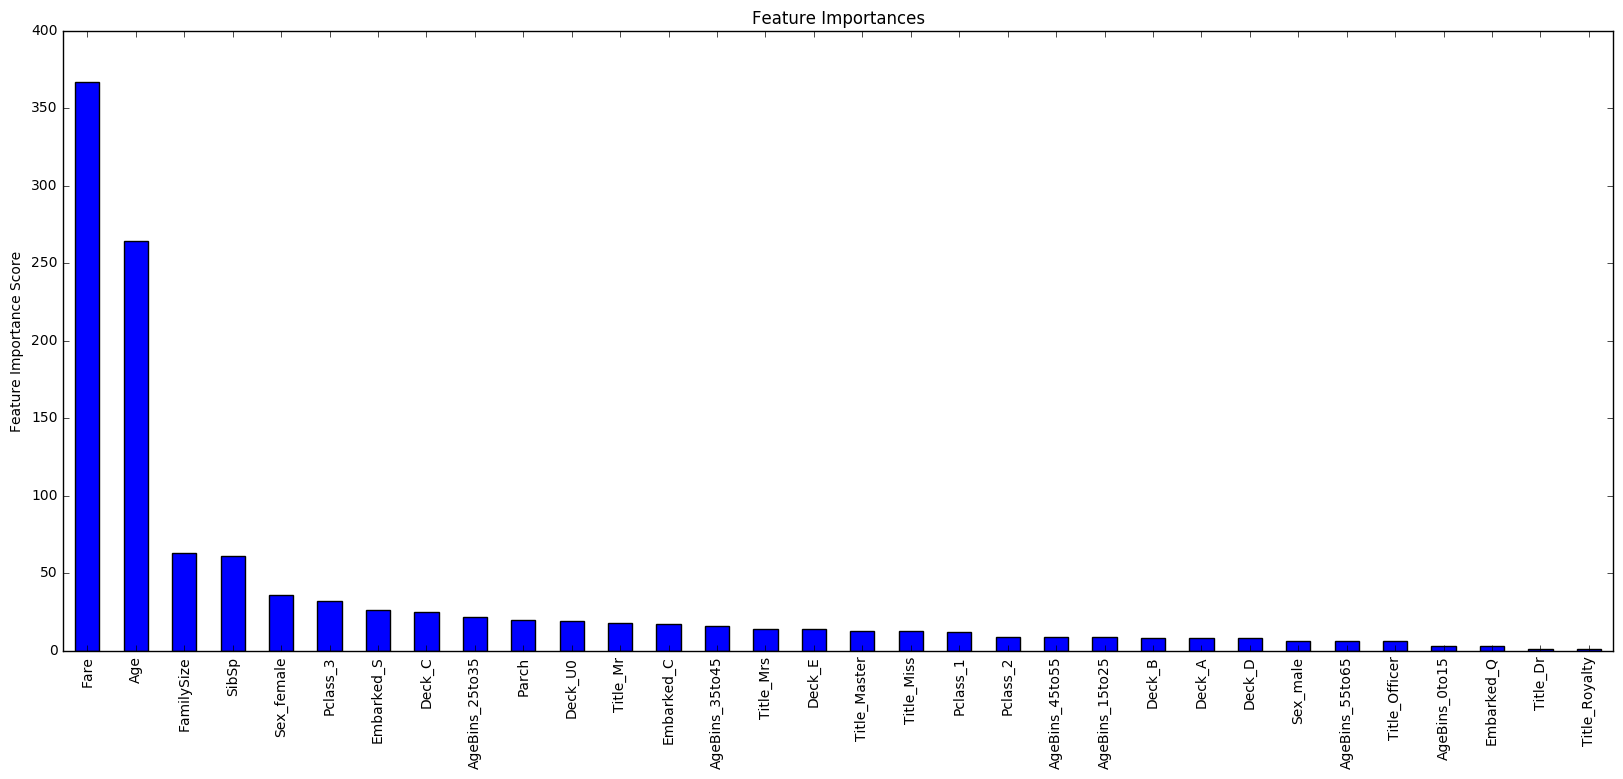

In [4]:
predictors = [x for x in train.columns if x not in ['Survived','PassengerId'] ]
xgb_param = {
    'eta': 0.1,
    'n_estimators':1000,
    'max_depth':6,
    'min_child_weight':1,
    'gamma':0,
    'subsample':0.8,
    'colsample_bytree':0.8,
    'objective':'binary:logistic',
    'scale_pos_weight':1,
    'seed': random_seed,
    'eval_metric':'auc',
    'alpha': 0,
    
}
xgb_model,xgb_param = modelfit(xgb_param, train, predictors)

**to use scikit wrapper**

In [5]:
xgb_sci_api={
    'eta': 'learning_rate',
    'n_estimators':'n_estimators',
    'max_depth':'max_depth',
    'min_child_weight':'min_child_weight',
    'gamma':'gamma',
    'subsample':'subsample',
    'colsample_bytree':'colsample_bytree',
    'objective':'objective',
    'scale_pos_weight':'scale_pos_weight',
    'seed':'seed',
    'alpha': 'reg_alpha',
    
}

def to_scikit_clf(params):
    model_kwarg={}
    for i in xgb_sci_api:
        model_kwarg[xgb_sci_api[i]] = params[i]
    return model_kwarg

In [6]:
xgb_clf = xgb.XGBClassifier(**to_scikit_clf(xgb_param))
xgb_clf.get_params
xgb_clf.set_params(nthread = 1)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.8,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=6,
       min_child_weight=1, missing=None, n_estimators=49, nthread=1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=0.8)

In [7]:
param_test = {
 'max_depth':[3,4,5,6,7,8],
 'min_child_weight':[1,2,3,4,5,6,7,8]
}

gsearch = GridSearchCV(estimator = xgb_clf, param_grid = param_test,\
                       scoring='roc_auc',n_jobs=4,iid=False, cv=5,verbose =0)
gsearch.fit(train[predictors],train['Survived'])

xgb_param['max_depth'] = gsearch.best_params_[xgb_sci_api['max_depth']]
xgb_param['min_child_weight'] = gsearch.best_params_[xgb_sci_api['min_child_weight']]

gsearch.grid_scores_, gsearch.best_params_, gsearch.best_score_

([mean: 0.87171, std: 0.03512, params: {'min_child_weight': 1, 'max_depth': 3},
  mean: 0.86967, std: 0.03436, params: {'min_child_weight': 2, 'max_depth': 3},
  mean: 0.87218, std: 0.03257, params: {'min_child_weight': 3, 'max_depth': 3},
  mean: 0.87080, std: 0.03300, params: {'min_child_weight': 4, 'max_depth': 3},
  mean: 0.87084, std: 0.03031, params: {'min_child_weight': 5, 'max_depth': 3},
  mean: 0.87180, std: 0.02844, params: {'min_child_weight': 6, 'max_depth': 3},
  mean: 0.87330, std: 0.02905, params: {'min_child_weight': 7, 'max_depth': 3},
  mean: 0.87274, std: 0.02685, params: {'min_child_weight': 8, 'max_depth': 3},
  mean: 0.86968, std: 0.03110, params: {'min_child_weight': 1, 'max_depth': 4},
  mean: 0.87114, std: 0.03238, params: {'min_child_weight': 2, 'max_depth': 4},
  mean: 0.87331, std: 0.03469, params: {'min_child_weight': 3, 'max_depth': 4},
  mean: 0.87331, std: 0.03233, params: {'min_child_weight': 4, 'max_depth': 4},
  mean: 0.87548, std: 0.03197, params: {

**Reduce eta to get final model**

[0]	train-auc:0.864339+0.0072693	test-auc:0.849141+0.0222614
[1]	train-auc:0.87027+0.00784481	test-auc:0.853821+0.0217787
[2]	train-auc:0.874566+0.00741238	test-auc:0.860952+0.0261563
[3]	train-auc:0.878016+0.00480905	test-auc:0.862515+0.027139
[4]	train-auc:0.879234+0.00458769	test-auc:0.863646+0.0282173
[5]	train-auc:0.880143+0.00667116	test-auc:0.865782+0.0287314
[6]	train-auc:0.880725+0.00677115	test-auc:0.86651+0.0291529
[7]	train-auc:0.88082+0.00713428	test-auc:0.86692+0.0291405
[8]	train-auc:0.882835+0.00576523	test-auc:0.868233+0.0289567
[9]	train-auc:0.882794+0.00569246	test-auc:0.868497+0.0279767
[10]	train-auc:0.882744+0.00555693	test-auc:0.867626+0.0286716
[11]	train-auc:0.883027+0.00544445	test-auc:0.867187+0.0284447
[12]	train-auc:0.883188+0.0049323	test-auc:0.866402+0.0270525
[13]	train-auc:0.883749+0.0049187	test-auc:0.86584+0.0270549
[14]	train-auc:0.884056+0.00434951	test-auc:0.866068+0.0269197
[15]	train-auc:0.884294+0.00473991	test-auc:0.865396+0.0275166
[16]	train-

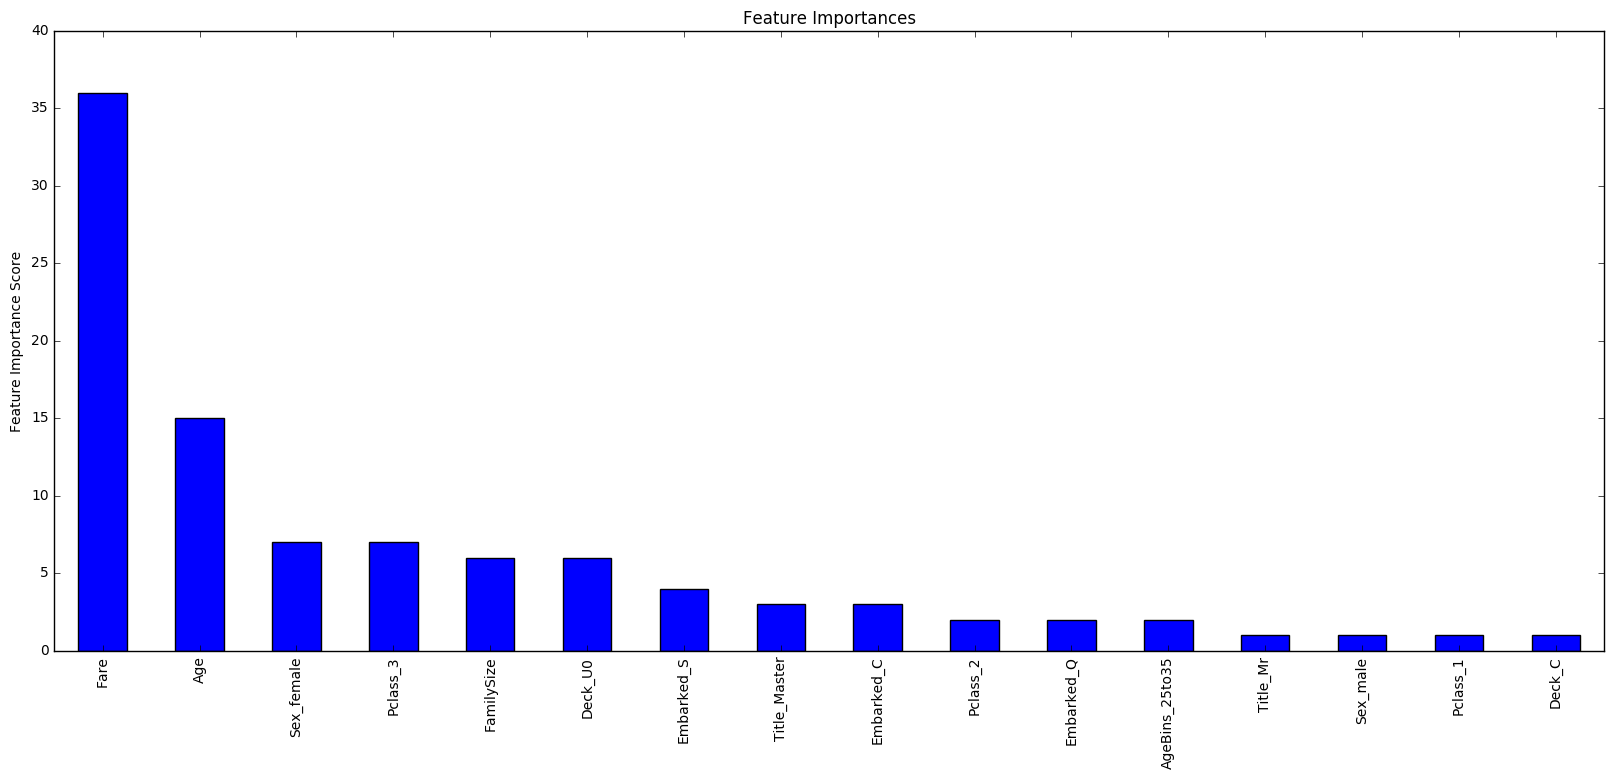

In [8]:
xgb_param['eta'] = 0.01
xgb_param['n_estimators'] = 1000
xgb_model,xgb_param = modelfit(xgb_param, train, predictors)

**Find the optimal threshold to determine survived or not**

In [9]:
dx_train = xgb.DMatrix(train[predictors].values,feature_names = predictors)
dtrain_predprob = xgb_model.predict(dx_train)

opt_threshold = 0
best_accu_score = 0
for i in range(0,100,1):
    accu_score =  metrics.accuracy_score(train.Survived.values, (dtrain_predprob>i/100).astype(int))
    if accu_score > best_accu_score:
        best_accu_score = accu_score
        opt_threshold = i/100
    print("threshold: {:.2f}, accuracy: {}".format(i/100, accu_score))
    
print("\n")
print("optimal threshold: {}, accuracy: {}".format(opt_threshold, best_accu_score))
    

threshold: 0.00, accuracy: 0.3838383838383838
threshold: 0.01, accuracy: 0.3838383838383838
threshold: 0.02, accuracy: 0.3838383838383838
threshold: 0.03, accuracy: 0.3838383838383838
threshold: 0.04, accuracy: 0.3838383838383838
threshold: 0.05, accuracy: 0.3838383838383838
threshold: 0.06, accuracy: 0.3838383838383838
threshold: 0.07, accuracy: 0.3838383838383838
threshold: 0.08, accuracy: 0.3838383838383838
threshold: 0.09, accuracy: 0.3838383838383838
threshold: 0.10, accuracy: 0.3838383838383838
threshold: 0.11, accuracy: 0.3838383838383838
threshold: 0.12, accuracy: 0.3838383838383838
threshold: 0.13, accuracy: 0.3838383838383838
threshold: 0.14, accuracy: 0.3838383838383838
threshold: 0.15, accuracy: 0.3838383838383838
threshold: 0.16, accuracy: 0.3838383838383838
threshold: 0.17, accuracy: 0.3838383838383838
threshold: 0.18, accuracy: 0.3838383838383838
threshold: 0.19, accuracy: 0.3838383838383838
threshold: 0.20, accuracy: 0.3838383838383838
threshold: 0.21, accuracy: 0.38383

**Predict on test set and make the submission**

In [10]:
test = pd.read_csv('./input/processed_test.csv')
test = test.rename(columns = {'AgeBins_(0, 15]':'AgeBins_0to15',
                                'AgeBins_(15, 25]':'AgeBins_15to25',
                                'AgeBins_(25, 35]':'AgeBins_25to35',
                                'AgeBins_(35, 45]':'AgeBins_35to45',
                                'AgeBins_(45, 55]':'AgeBins_45to55',
                                'AgeBins_(55, 65]':'AgeBins_55to65',
                                'AgeBins_(65, 75]':'AgeBins_65to75',
                                'AgeBins_(75, 85]':'AgeBins_75to85'                                    
                                })

In [ ]:
test_id = test.PassengerId

dx_test = xgb.DMatrix(test[predictors].values,feature_names = predictors)
test_predprob = xgb_model.predict(dx_test)

submission = pd.DataFrame({'PassengerId':test_id,'Survived':(test_predprob>opt_threshold).astype(int)})
submission.to_csv("submission_tiantic_xgb.csv", index=False)